### Daytum Course: Spatial Data Analytics

### Spatial Modeling Checking

There are a variety of spatial data analytics / geostatistics methods for estimation and simulation of spatial phenomenon. I cover many of these methods in my courses, lectures and demonstration workflows available on YouTube and GitHub.For example:

* [Kriging YouTube Lecture](https://youtu.be/CVkmuwF8cJ8)
* [Simulation YouTube Lecture](https://www.youtube.com/watch?v=3cLqK3lR56Y&list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ&index=45&t=813s)
* I provide a Python package, known as [GeostatsPy](https://pypi.org/project/geostatspy/) (Pyrcz et al., 2021)

Yet, when we calculate these spatial deterministic estimates or stochastic realizations we must check these models. Here I provide a Python demonstration of spatial model checking inspired by the work of Leuangthong et al. (2004) known as [Minimum Acceptance Criteria for Geostatistical Realizations](https://link.springer.com/article/10.1023/B:NARR.0000046916.91703.bb).

I simulate a set of realizations for a publically available [dataset](https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv) from my GitHub account and include codes and good displays for each of the following checks:

1. Visualize the Spatial Models
2. Data Reproduction
3. Global Distributions - Summary Statistics
4. Global Distributions - PDFs and CDFs
5. Spatial Continuity - Variograms
6. Local Uncertainty Model - e-type and Conditional Standard Deviation

This is a basic demonstration and more could be done. 

* the models are 2D and univariate
* more checks such as accuracy plots for uncertainty cross validation could be applied

I have attempted to balance the need for a simple introduction for my students and others.

#### Load the Required Libraries

The following code loads the required libraries.

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import seaborn as sns                                     # advanced statistical methods and plots
cmap = plt.cm.inferno                                     # color map
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB
import warnings
warnings.filterwarnings('ignore')

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting variograms and calculating local summaries over realizations.

In [2]:
def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill):     # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'black',s = npps_maj*0.01,label = 'Major Azimuth ' +str(azi), alpha = 0.2)
    plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = npps_min*0.01,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.2)
    plt.plot(lags_min,gmod_min,color = 'red')
    plt.plot([0,2000],[sill,sill],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Directional ' + feature + ' Variogram')
    else: 
        plt.title('Omni Directional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,1000]); #plt.ylim([0,1.8])
    plt.legend(loc="lower right")
    plt.grid(True)
    
def local_expectation(realizations):                      # calculate the local expectation / average realization
    cond_exp = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            cond_exp[iy,ix] = np.average(a = realizations[:,iy,ix])  
    return cond_exp

def local_standard_deviation(realizations):               # calculate the local standard deviation of realizations
    local_stdev = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            local_stdev[iy,ix] = np.std(a = realizations[:,iy,ix])  
    return local_stdev

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [3]:
dataset = 1

if dataset == 1:
    #df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
    df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
    df['Porosity'] = df['Porosity']*100                                  # convert from fraction to percentage
    azi_maj = 45
elif dataset == 2:
    #df = pd.read_csv("spatial_nonlinear_MV_facies_v1.csv")    # read a .csv file in as a DataFrame
    df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv")
    df = df.rename(columns = {'Por':'Porosity'})            # rename feature(s)
    azi_maj = 135
else:
    raise Exception('Data Index = ' + str(dataset) + ' not available!')
    
df = df.loc[:,['X','Y','Porosity']];
df.describe()                                             # summary statistics 

,X,Y,Porosity
count,368.000000,368.000000,368.000000
mean,499.565217,520.644022,12.702582
std,289.770794,277.412187,3.064227
min,0.000000,9.000000,4.112152
25%,240.000000,269.000000,10.341201
50%,500.000000,539.000000,12.584177
75%,762.500000,769.000000,14.862292
max,990.000000,999.000000,21.025763


#### Set Limits for Plotting

This is applied for data and model visualization.

In [4]:
pormin = 0.0; pormax = 25.0; pormean = 12.7
xmin = 0.0; xmax = 1000.0
ymin = 0.0; ymax = 1000.0
tmin = -9999.9; tmax = 9999.9
nx = 50; xmn = 10.0; xsiz = 20.0
ny = 50; ymn = 10.0; ysiz = 20.0
nreal = 12

#### Data Analytics and Visualization

Let's take a look at the available data:

* location map
* histogram
* variogram

 x,y,z offsets = 7.071067805519558,7.071067818211393


 x,y,z offsets = 7.071067830903227,-7.071067792827723


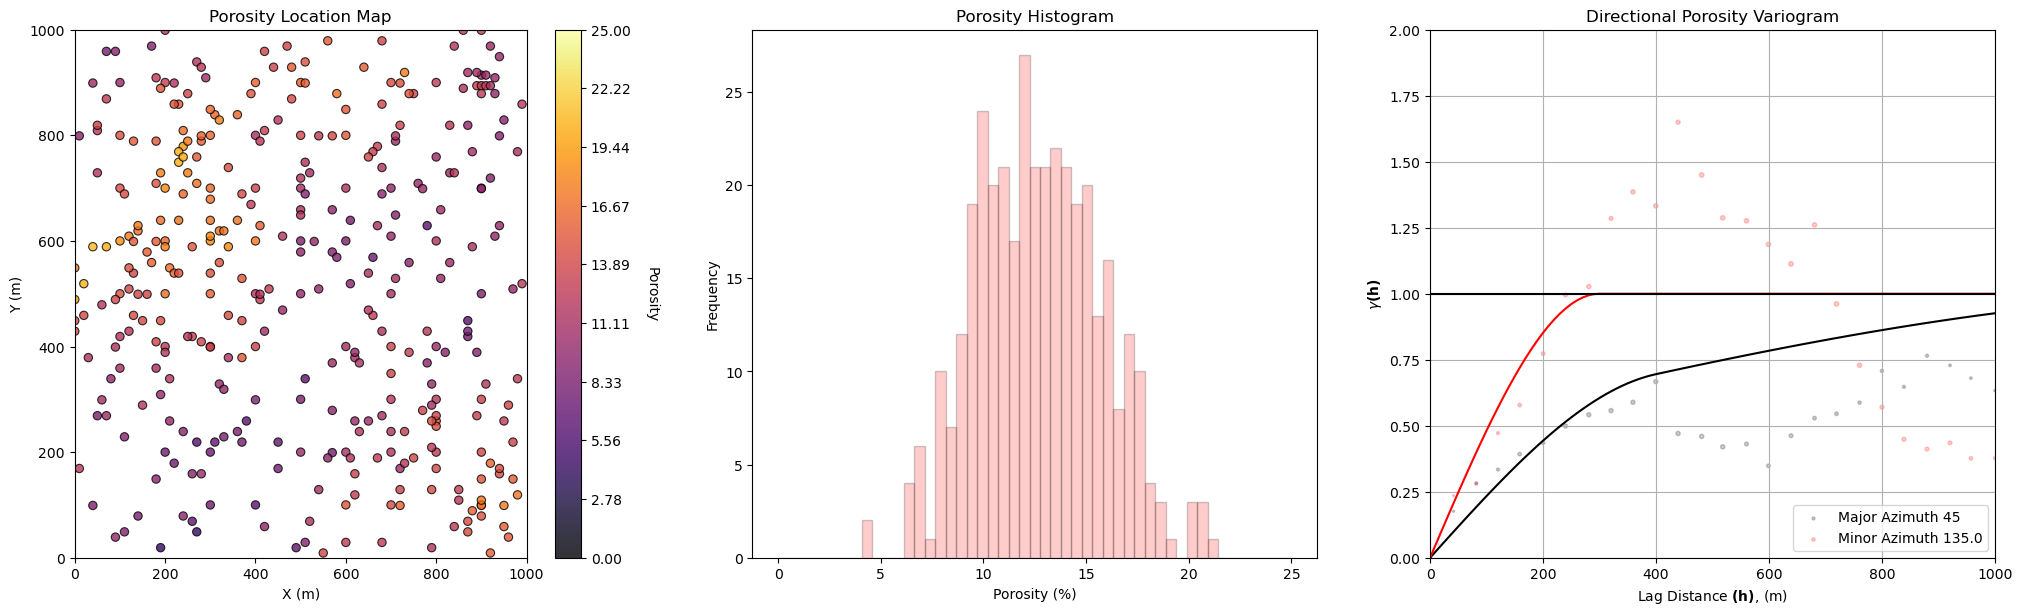

In [5]:
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,25,'Porosity Location Map','X (m)','Y (m)','Porosity',cmap=cmap)

plt.subplot(132)
plt.hist(df['Porosity'].values,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.2,edgecolor='black')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram')

df['Npor'], tvPor, tnsPor = geostats.nscore(df,'Porosity') 
lags, gamma_maj, npps_maj = geostats.gamv(df,"X","Y",'Npor',tmin,tmax,xlag=40,xltol=20,nlag=100,azm=azi_maj,atol=12.5,bandwh=9999.9,isill=0);
lags, gamma_min, npps_min = geostats.gamv(df,"X","Y",'Npor',tmin,tmax,xlag=40,xltol=20,nlag=100,azm=azi_maj+90.0,atol=12.5,bandwh=9999.9,isill=0);

if dataset == 1:
    nug = 0.0; nst = 2                                             # 2 nest structure variogram model parameters
    it1 = 1; cc1 = 0.5; azi1 = azi_maj; hmaj1 = 400; hmin1 = 300
    it2 = 1; cc2 = 0.5; azi2 = azi_maj; hmaj2 = 1500; hmin2 = 300
elif dataset == 2:
    nug = 0.0; nst = 2                                             # 2 nest structure variogram model parameters
    it1 = 1; cc1 = 0.8; azi1 = azi_maj; hmaj1 = 50; hmin1 = 150
    it2 = 1; cc2 = 0.2; azi2 = mazi_maj; hmaj2 = 1000; hmin2 = 650

vmodel = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2); # make model object

plt.subplot(133)
vargplot('Porosity',lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi=azi_maj,atol=22.5,sill=1.0)     # plot the variogram
plt.ylim([0,2.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Build an Example Modeling: Sequential Gaussian Simulated Realizations

Let's simulate a set of realizations with sequential Gaussian simulation ([GeostatsPy Python Package](https://pypi.org/project/geostatspy/) (Pyrcz et al., 2021) reimplemented from the original geostatistics open source, [GSLIB](http://www.gslib.com/) (Deutsch and Journel, 1997).

* we demonstrate 12 realizations by changing the random number seed. 
* this workflow and each check are general and could be applied to any set of spatial models representing uncertainty 

In [6]:
run = True; nreal = 12                                        # number of realizations

if run == True:
    por_sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
        dftrans=0,tcol=0,twtcol=0,zmin=pormin,zmax=pormax,ltail=1,ltpar=pormin,utail=1,utpar=pormax,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
        ndmin=0,ndmax=20,nodmax=20,mults=0,nmult=2,noct=-1,
        ktype=0,colocorr=0.0,sec_map=0,vario=vmodel)
    GSLIB.ndarray2GSLIB_3D(por_sim,"por_sim_realizations.dat","porosity") # write out 2D array to a Geo-DAS ASCII file
else: 
    por_sim = GSLIB.GSLIB2ndarray_3D("por_sim_realizations.dat",0,nreal,nx,ny,1)[0]


 Data for SGSIM: Number of acceptable data     = 368
                 Number trimmed                = 0
                 Weighted Average              = 12.7026
                 Weighted Variance             = 9.364
                 Weighted Transformed Average  = 0.0002
                 Weighted Transformed Variance = 0.997
Setting up rotation matrices for variogram and search


Working on realization number 0
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 0: number   = 2500
                                   mean     = -0.2013 (close to 0.0?)
                                   variance = 0.9381 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 1
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 1: number   = 2500
                                   mean     = -0.2099 (close to 0.0?)
                                   variance = 0.9711 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 2
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 2: number   = 2500
                                   mean     = -0.2246 (close to 0.0?)
                                   variance = 0.9896 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 3
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 3: number   = 2500
                                   mean     = -0.2009 (close to 0.0?)
                                   variance = 0.8877 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 4
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 4: number   = 2500
                                   mean     = -0.2348 (close to 0.0?)
                                   variance = 0.9727 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 5
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 5: number   = 2500
                                   mean     = -0.2078 (close to 0.0?)
                                   variance = 0.9811 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 6
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 6: number   = 2500
                                   mean     = -0.2035 (close to 0.0?)
                                   variance = 0.9317 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 7
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 7: number   = 2500
                                   mean     = -0.2098 (close to 0.0?)
                                   variance = 0.8979 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 8
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 8: number   = 2500
                                   mean     = -0.2737 (close to 0.0?)
                                   variance = 1.009 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 9
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 9: number   = 2500
                                   mean     = -0.2138 (close to 0.0?)
                                   variance = 0.8947 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 10
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 10: number   = 2500
                                   mean     = -0.255 (close to 0.0?)
                                   variance = 0.9639 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 11
   currently on node 0


   currently on node 250


   currently on node 500


   currently on node 750


   currently on node 1000


   currently on node 1250


   currently on node 1500


   currently on node 1750


   currently on node 2000


   currently on node 2250


Reassigning data to nodes

 Realization 11: number   = 2500
                                   mean     = -0.207 (close to 0.0?)
                                   variance = 0.9284 (close to gammabar(V,V)? approx. 1.0)


Now we are ready to step through the spatial model checks.

#### Model Check \#1: Visualize the Spatial Models

Look at the spatial estimates and / or stochastic realizations and check for common issues such as:

* **missing values** - part of the model not simulated
* **rotated, flipped or translated** - issues with the coordinate scheme
* **search artifacts** - discontinuities and rays caused by overly limited radius or maximum number of data
* **data not present** - error in data loading or data to grid consistency
* **extrapolation** - unexpected behavoir of the model away from the data

Visualization of the model realizations is an important first check.

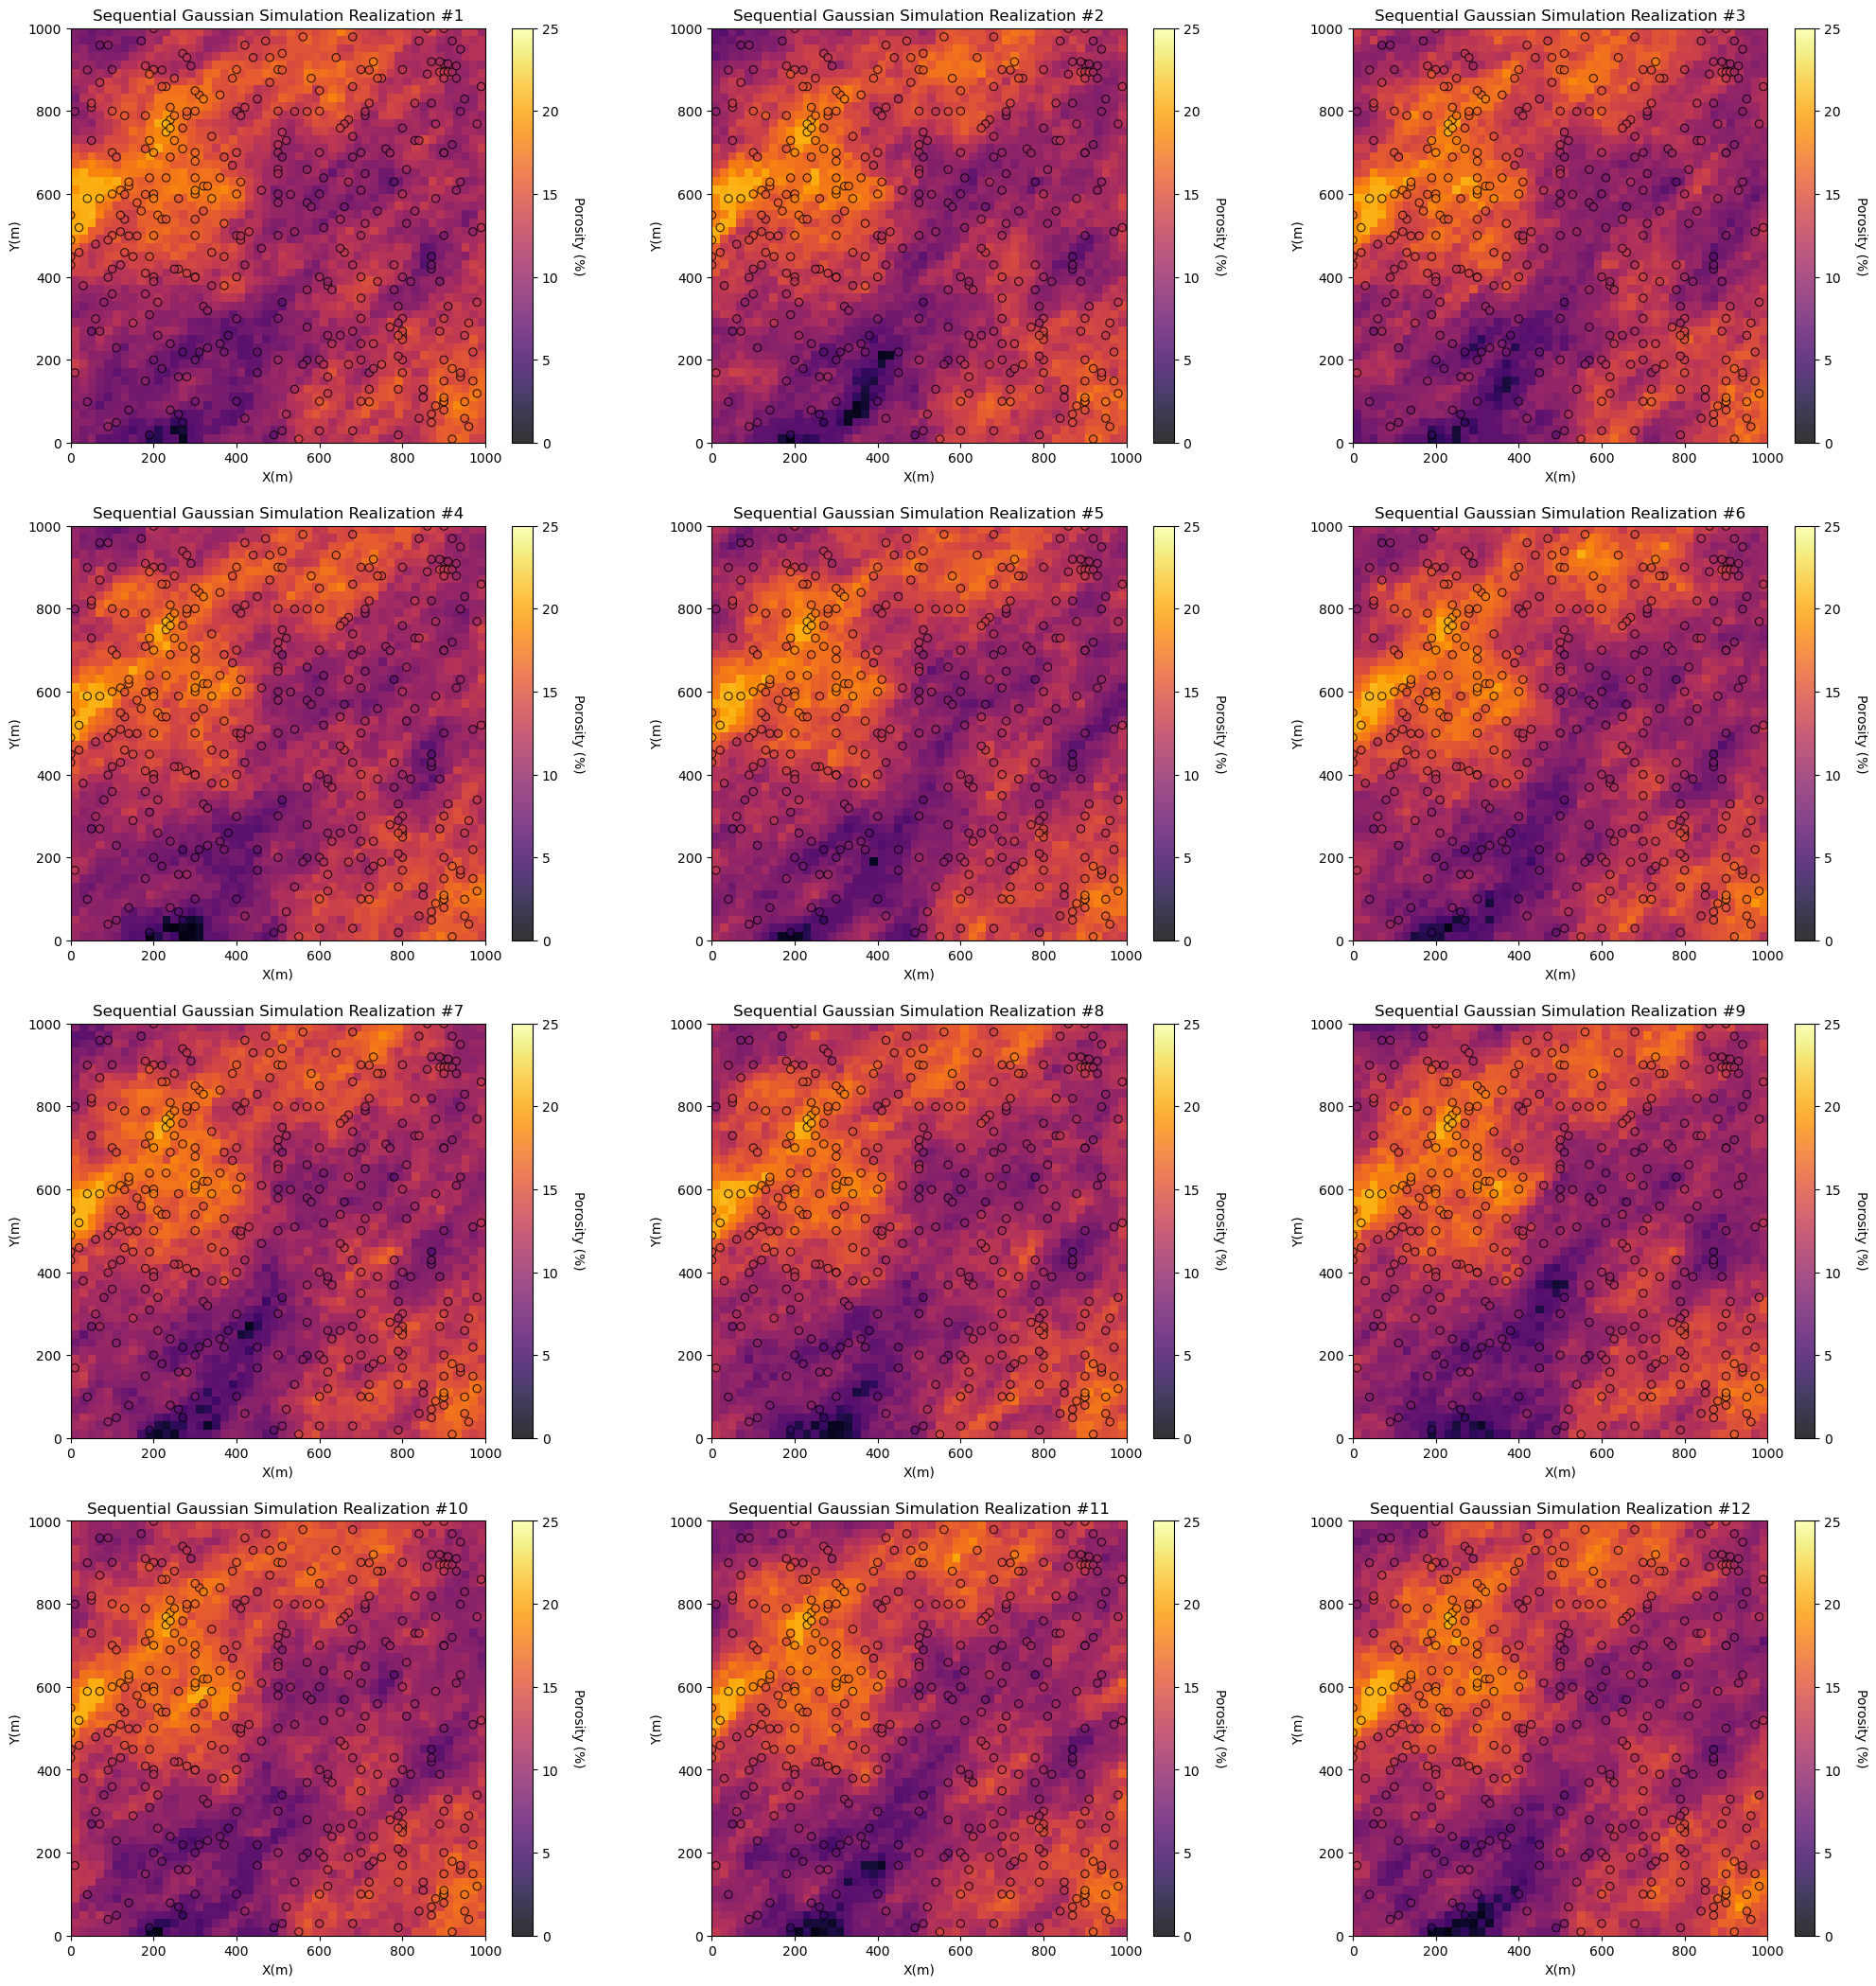

In [7]:
for ireal in range(0,nreal):    
    plt.subplot(4,3,ireal+1)                                  # plot the data and realizations
    GSLIB.locpix_st(por_sim[ireal,:,:],xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Sequential Gaussian Simulation Realization #' + str(ireal+1),'X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=4.2, wspace=0.2, hspace=0.2); plt.show()

For the provided data the models 'look good'. 

* the data shown in the model space
* the models honor the data at the data locations
* the heterogeneity is consistent over the models
* there are no missing values etc.

#### Model Check \#2: Data Reproduction

We need to check the reproduction of the data values at the data locations. Data is important and expensive, a model that fails to honor the data will not forecast well and will certainly loose credibility. 

Some further comments:

* **data scaling** - the data should be first scaled to the model grid cell scale
* **built-in scaling** - some methods have built in scaling that may cause apparent data and model mismatch
* **assignment of data to nearest cell** - some methods automatically do this resulting in perfect reproduction, SGSIM in GeostatsPy does not do this, so there is likely some scatter due to the assumption of point data 

We will find the cell that includes each data point and report the associated simulated realizations vs. the data points.

* we should see some vertical striations due to multiple realizations for each data value

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 343.21it/s]

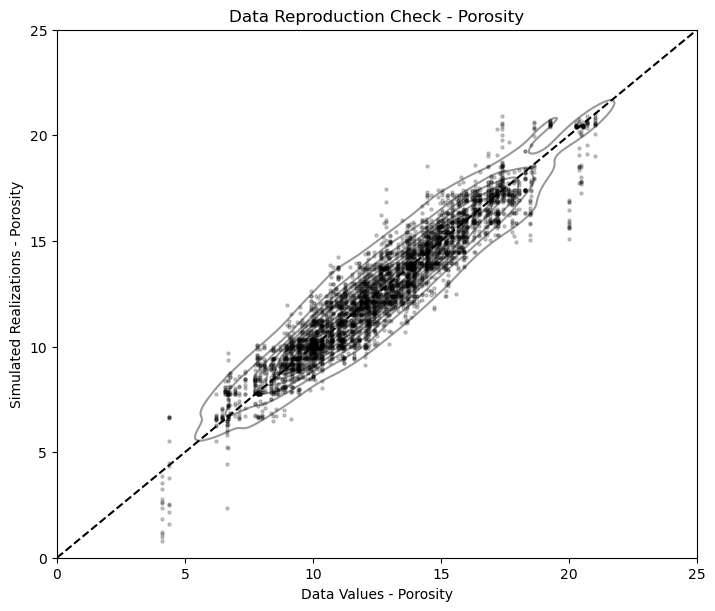

In [8]:
plt.subplot(111)
df_vstack = GSLIB.conditioning_check(model=por_sim,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,nreal=nreal,
        df=df,xcol='X',ycol='Y',vcol='Porosity',vname='Porosity',vmin=0.0,vmax=25)
sns.kdeplot(data=df_vstack, x="Data", y="Real",color='black',alpha=0.4,label ="Train Density") # estimate joint PDF
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Due to the use of point data and cells represented by points at the cell centroids, there is some scatter in the result above.

#### Model Check \#3: Global Distributions - Summary Statistics

While there will be ergodic fluctuations in reproduction of any statistics, we check the summary statistics of the global distribution for good match over the realizations, in expectation.

Here's some issues that we may see:

* **systematic bias** - measures of central tendency that are consistently shifted
* **reduced variance** - various modeling methods are subjected to regression to the mean, artificial loss in variance
* **outliers** - unusual estimated or simulated values

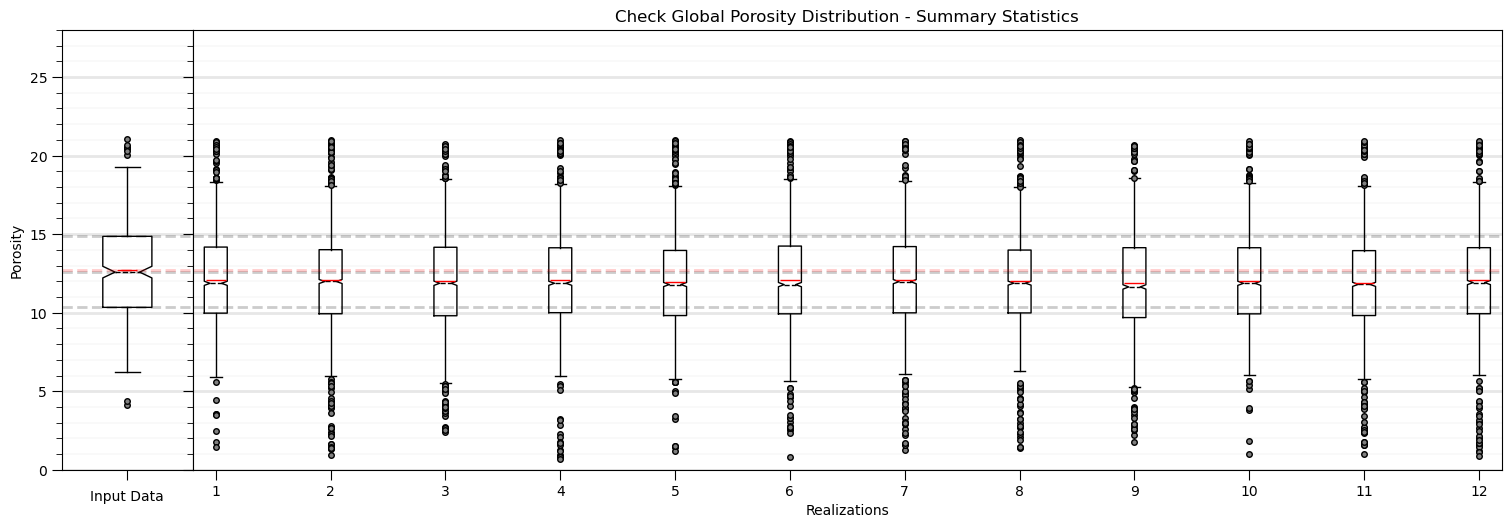

In [9]:
GSLIB.distribution_check(df=df,vcol='Porosity',model=por_sim,nx=nx,ny=ny,nreal=12,dreal=12,vname='Porosity',vmin=0.0,vmax=28.0)
plt.subplots_adjust(left=0.0, bottom=0.0, wspace=0.0, hspace=0.2); plt.show()

In general, this look pretty good. Some observations:

* there may be a shift low in the central tendency likely caused by the dense, clustered data, informing a degree of declustering in the simulation.
* otherwise the fluctuations are not extreme and could be checked with theory, e.g., analytical volume variance relations

#### Model Check \#4: Global Distributions - PDFs and CDFs

We can go beyond summary statistics and check the entire global distribution of the realizations vs. the input data. We check the probability density functions (PDFs) (infered with kernel density estimation) and cumulative distribution functions (CDFs).

* we check the shape, including the modes, symmetry and tails

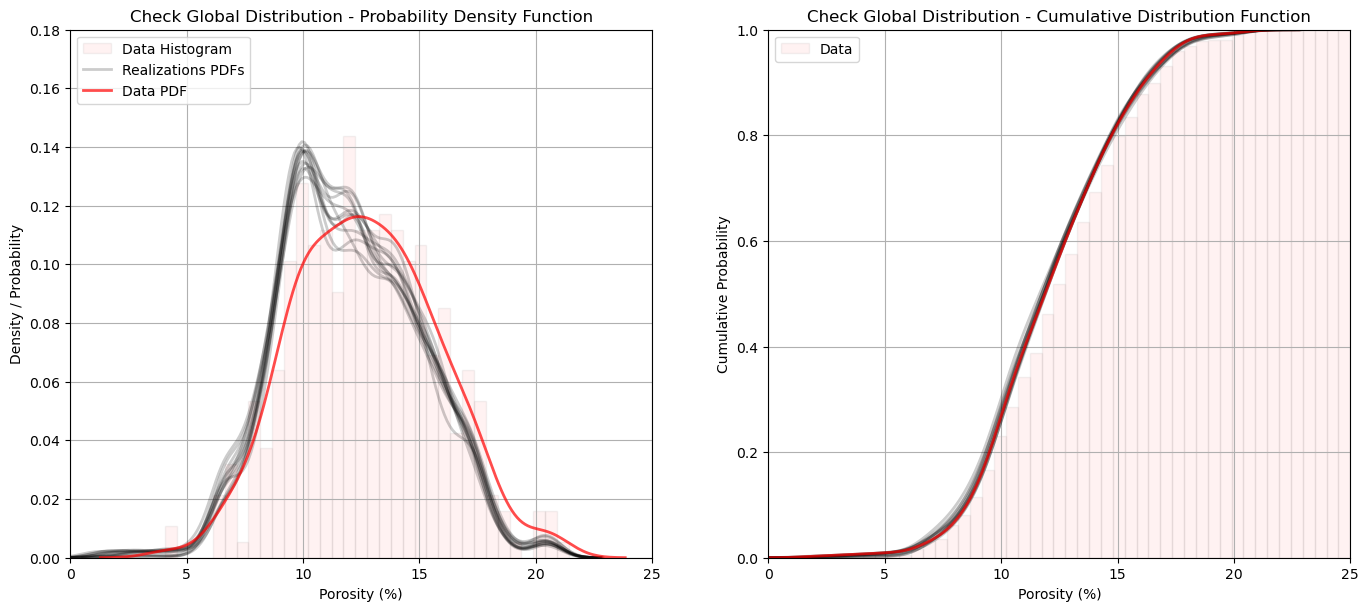

In [10]:
plt.subplot(121)
plt.hist(df['Porosity'].values,density=True,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.05,edgecolor='black',label='Data Histogram')
for ireal in range(1,nreal):
    sns.kdeplot(por_sim[ireal,:,:].flatten(), color = 'black',alpha=0.2,linewidth = 2)
    plt.xlabel('Porosity (%)'); plt.ylabel('Density / Probability'); plt.title('Check Global Distribution - Probability Density Function')
sns.kdeplot(por_sim[0,:,:].flatten(), color = 'black',alpha=0.2,linewidth = 2,label='Realizations PDFs')
sns.kdeplot(df['Porosity'].values, color = 'red',alpha=0.7,linewidth=2.0,label='Data PDF')
plt.xlim([0,25]); plt.ylim([0,0.18]); plt.grid(True); plt.legend(loc='upper left')

plt.subplot(122)
plt.hist(df['Porosity'].values,density=True,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.05,edgecolor='black',label='Data',cumulative=True)
for ireal in range(0,nreal):
    sns.kdeplot(por_sim[ireal,:,:].flatten(), color = 'black',alpha=0.2,linewidth = 2,cumulative=True)
    plt.xlabel('Porosity (%)'); plt.ylabel('Cumulative Probability'); plt.title('Check Global Distribution - Cumulative Distribution Function')
sns.kdeplot(por_sim[ireal,:,:].flatten(), color = 'red',alpha=0.7,linewidth=2,cumulative=True)
plt.xlim([0,25]); plt.ylim([0,1]); plt.grid(True); plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

The reproduction of the data distribution shape looks very good. I include the regular data normalized histogram to help visualize the impact of the kernel density estimate of the PDF.

* there is a minor shift in the mean and mode as discussed previously.

#### Model Check \#5: Spatial Continuity - Variograms

The variogram is an input statistic to constrain spatial continuity for sequential Gaussian simulation. Let's check the reproduction of the variogram. Some common issues:

* **underrepresent the range** - this is typically caused by overly limited search for nearest data and previously simulated nodes
* **trend structures** - even if the variogram is modeled to the sill and mean assumed to be stationary, dense data may impart a trend in the simulated realizations
* **scale change** - the raw data may represent very small lag distances, while the grid has a reoslution limit based on the cell size

 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067830903227,-7.071067792827723


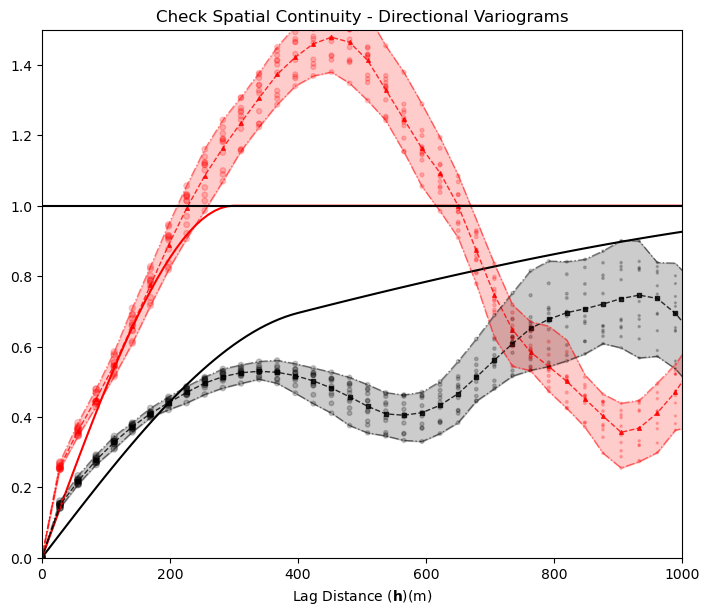

In [11]:
nlag = 40
gamma_maj = np.zeros([nlag,nreal]); gamma_min = np.zeros([nlag,nreal])
npps_maj = np.zeros([nlag,nreal]); npps_min = np.zeros([nlag,nreal]);

if dataset == 1:
    ixd_maj = 1; iyd_maj = -1; ixd_min = 1; iyd_min = 1

for ireal in range(0,nreal):
    lags, gamma_maj[:,ireal], npps_maj[:,ireal] = geostats.gam(por_sim[ireal,:,:],tmin,tmax,xsiz,ysiz,ixd=ixd_maj,iyd=iyd_maj,nlag=nlag,isill=1.0);
    lags, gamma_min[:,ireal], npps_min[:,ireal] = geostats.gam(por_sim[ireal,:,:],tmin,tmax,xsiz,ysiz,ixd=ixd_min,iyd=iyd_min,nlag=nlag,isill=1.0);
gamma_maj[0,:] = 0.0; gamma_min[0,:] = 0.0
   
index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi_maj,vario=vmodel);
index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi_maj+90.0,vario=vmodel);
        
plt.subplot(111)
plt.plot(lags_maj,gmod_maj,color = 'black')
plt.plot(lags_min,gmod_min,color = 'red')
#vargplot('Porosity',lags,gamma_maj[:,0],gamma_min[:,0],npps_maj[:,0],npps_min[:,0],vmodel,azi=135.0,atol=22.5,sill=1.0)     # plot the variogram
for ireal in range(1,nreal):
    plt.scatter(lags,gamma_maj[:,ireal],color = 'black',s = npps_maj[:,ireal]*0.01,alpha = 0.2)
    plt.scatter(lags,gamma_min[:,ireal],color = 'red',s = npps_min[:,ireal]*0.01,alpha = 0.2)
plt.ylim([0,1.5]); plt.title('Check Spatial Continuity - Directional Variograms')
plt.scatter(lags,np.average(gamma_maj,axis=1),marker='s',color = 'black',s = 7,alpha = 0.8)
plt.plot(lags,np.average(gamma_maj,axis=1),color = 'black',linewidth = 1,alpha = 0.8,linestyle='--')
plt.scatter(lags,np.average(gamma_min,axis=1),marker='^',color = 'red',s = 7,alpha = 0.8)
plt.plot(lags,np.average(gamma_min,axis=1),color = 'red',linewidth = 1,alpha = 0.8,linestyle='--')
plt.plot(lags,np.min(gamma_maj,axis=1),color = 'black',linewidth = 1,alpha = 0.5,linestyle='-.')
plt.plot(lags,np.max(gamma_maj,axis=1),color = 'black',linewidth = 1,alpha = 0.5,linestyle='-.')
plt.fill_between(lags,np.min(gamma_maj,axis=1),np.max(gamma_maj,axis=1),color='black',alpha=0.2)
plt.plot(lags,np.min(gamma_min,axis=1),color = 'red',linewidth = 1,alpha = 0.5,linestyle='-.')
plt.plot(lags,np.max(gamma_min,axis=1),color = 'red',linewidth = 1,alpha = 0.5,linestyle='-.')
plt.fill_between(lags,np.min(gamma_min,axis=1),np.max(gamma_min,axis=1),color='red',alpha=0.2)
plt.xlim([0,1000]); plt.xlabel(r'Lag Distance ($\bf{h}$)(m)')
plt.plot([0,1000],[1.0,1.0],color='black')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

Note the cyclicity was not in the variogram model, but it is impose by the data. There is some inflation of short scale discontinuity that may the result of the limited model resolution.

#### Model Check \#6: Local Uncertainty Model - e-type and Conditional Standard Deviation

Finally, we should visualize the local expection and uncertainty model. To do this we calculate and plot the expectation and standard deviation of the realizations over all cell locations. What are we checking?

* **expectation matches data and trends** - the expectation should be consistent with data and trend models or the stationary mean in the absence of a trend model
* **low uncertainty near data** - the uncertainty should be minimized near conditioning data and maximize beyond the range of any conditioning data
* **heteroscedasticity or homoscedasticity** - the assumptions of homoscedasticity or heteroscedasticity will be apparent in the local standard deviation model and can be accessed for appropriateness. 

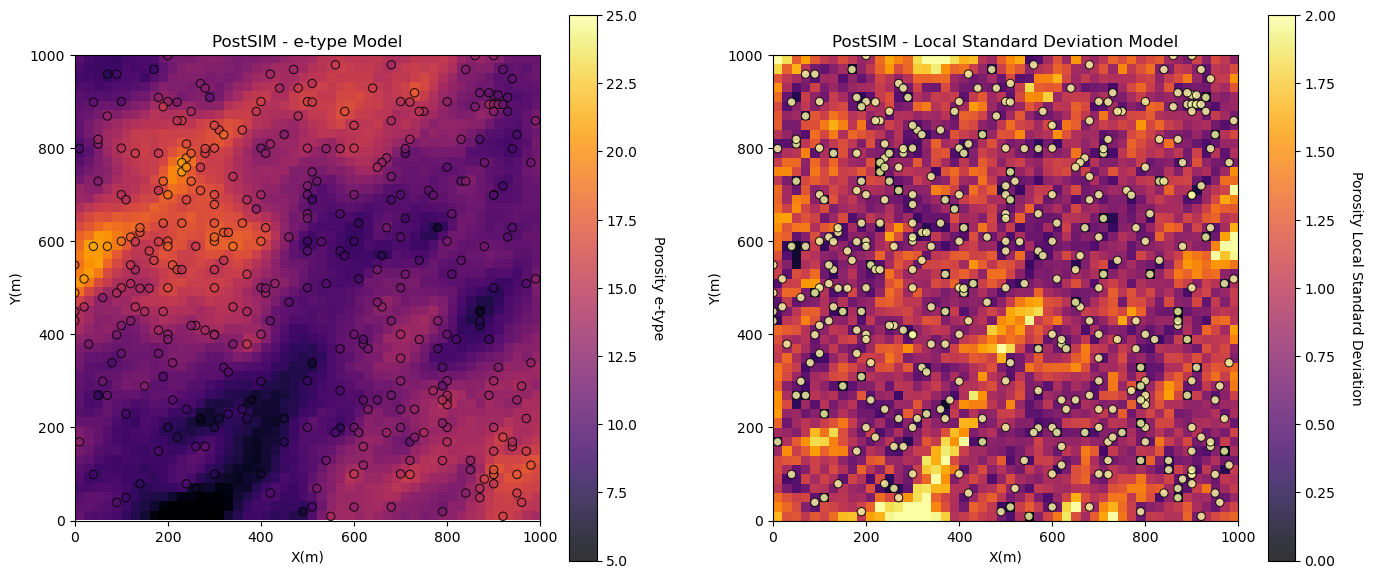

In [12]:
e_type = local_expectation(por_sim)
local_stdev = local_standard_deviation(por_sim)

plt.subplot(2,2,1)
GSLIB.locpix_st(e_type,xmin,xmax,ymin,ymax,xsiz,5,25,df,'X','Y','Porosity','PostSIM - e-type Model','X(m)','Y(m)','Porosity e-type',cmap)

plt.subplot(2,2,2)
GSLIB.locpix_st(local_stdev,xmin,xmax,ymin,ymax,xsiz,0.0,2.0,df,'X','Y','Porosity','PostSIM - Local Standard Deviation Model','X(m)','Y(m)','Porosity Local Standard Deviation',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

The local expectation and standard deviations are consistent with the data and appear reasonable.

#### Comments

This was a basic demonstration comparison of spatial model checking.   

<i>&copy; Copyright daytum 2025. All Rights Reserved</i>